In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.signal import find_peaks
from qiskit import IBMQ
from qiskit import pulse
import qiskit.pulse.library as pulse_lib
from qiskit.compiler import assemble
from qiskit.tools.monitor import job_monitor
from scipy.optimize import curve_fit

In [2]:
IBMQ.load_account()
provider = IBMQ.get_provider(hub='ibm-q', group='open', project='main')
backends =provider.backends()

In [3]:
def match_sine(X,ps,booltPlot=True):
    
    N=len(X)
    
    #init parameter
    C = np.mean(X)
    B = (np.max(X)-np.min(X))/2
    
    #init frequency
    Y = np.fft.fft(X - C)
    Y = np.abs(Y[:int(N/2)])
    
    imax = np.argmax(Y)
    y0 = Y[imax]
    yl = Y[imax-1]
    yr = Y[imax+1]

    a = (yl+yr)/2 - y0
    b = (yr-yl)/2
    c = y0

    x = -b/(2*a)
    dp = ps[1]-ps[0]
    p_opt = dp*(N-1)/(imax + x)/2
    
    #optim
    init_param = [p_opt, 0, -B, C]
    function = lambda f, fc, A, B, C: A*np.sin(np.pi*f/fc)+B*np.cos(np.pi*f/fc)+C
    params, conv = curve_fit(function, ps, X, init_param)
    X_model = function(ps, *params)
    
    if booltPlot == True:
        plt.plot(ps,X)
        plt.plot(ps,function(ps,*init_param))
        plt.plot(ps,X_model)
    
    return params

In [4]:
def match_sinc2(X,fs,boolPlot=True):
    
    #initial parameters
    B = np.min(X)
    fc = fs[np.argmax(X)]
    A = np.max(X) - B
    X_norm = (X - B)/A
    x_mean = np.mean(X_norm)
    df = x_mean*(np.max(fs)-np.min(fs))/np.pi/3
    
    #fit
    function = lambda f, fc, df, A, B: A*np.sinc((f-fc)/df)**2+B
    params, conv = curve_fit(function, fs, X, [fc, df, A, B])
    X_model = function(fs, *params)
    
#     (params, X_model) =fit_function(fs,X,function,[fc, df, A, B])
    
    if boolPlot == True:
        plt.scatter(fs,X,c='k')
        plt.plot(fs,X_model,c='b')
    
    return params

In [239]:
# number of shots for our experiments
NUM_SHOTS = 1024
SIGMA = 75e-9
TRUNC = 8
MAXEXP = 75
MAXDRIVE = 0.1
SAMPLE = 16
SCALE = 1e-14

class Calibration:
    def __init__(self,backend='ibmq_armonk'):
        self.backend = provider.get_backend(backend)
        self.backend_config = self.backend.configuration()
        assert self.backend_config.open_pulse, "Backend doesn't support Pulse"
        self.dt = self.backend_config.dt
        self.backend_defaults = self.backend.defaults()
    
    def gaussian_pulse(self,drive_power):
        # Define the drive pulse
        drive_sigma = SAMPLE * round(SIGMA/ SAMPLE/ self.dt)       # The width of the gaussian in units of dt
        drive_samples = TRUNC * drive_sigma   # The truncating parameter in units of dt
        gauss = pulse_lib.gaussian(duration=drive_samples,sigma=drive_sigma,amp=drive_power)
        return gauss
    
    def frequency01_schedules(self,span_range=1/200,qbit=0):
        schedules = []
        self.f01_default = self.backend_defaults.qubit_freq_est[qbit]
        span = self.f01_default*span_range
        frequencies = np.linspace(-span, span, MAXEXP)
        gauss = self.gaussian_pulse(drive_power = MAXDRIVE)
        
        for freq in frequencies:
            with pulse.build(backend=self.backend) as spec:
                with pulse.align_sequential():
                    pulse.shift_frequency(freq, pulse.DriveChannel(qbit))
                    pulse.play(gauss, pulse.DriveChannel(qbit))
                    pulse.measure(qbit)

            schedules.append(spec)
        
        return frequencies,schedules
    
    def amplitude01_schedules(self,max_amp=1.0,qbit=0):
        schedules = []
        drive_powers = np.linspace(0, max_amp, MAXEXP)

        for drive_power in drive_powers:
            gauss = gaussian_pulse(drive_power=drive_power)
            with pulse.build(backend=self.backend) as spec:
                with pulse.align_sequential():
                    pulse.shift_frequency(self.df01_calib, pulse.DriveChannel(qbit))
                    pulse.play(gauss, pulse.DriveChannel(qbit))
                    pulse.measure(qbit)

            schedules.append(spec)
        
        return drive_powers,schedules
    
    def frequency12_schedules(self,span=[-0.36e9, -0.32e9],qbit=0):
        schedules = []
        frequencies = np.linspace(span[0],span[1], MAXEXP)

        # Define the drive pulse
        pulse01 = self.pulse_rx01()
        
        for freq in frequencies:
            with pulse.build(backend=self.backend) as spec:
                with pulse.align_sequential():
                    pulse.shift_frequency(self.df01_calib, pulse.DriveChannel(qbit))
                    pulse.play(gauss, pulse.DriveChannel(0))
                    pulse.shift_frequency(freq, pulse.DriveChannel(qbit))
                    pulse.play(gauss, pulse.DriveChannel(qbit))
                    pulse.measure(qbit)

            schedules.append(spec)
        
        return frequencies,schedules
    
    def amplitude12_schedules(self,max_amp=1.0,qbit=0):
        schedules = []
        drive_powers = np.linspace(0, max_amp, MAXEXP)

        # Define the drive pulse
        drive_sigma = SAMPLE * round(SIGMA/ SAMPLE/ self.dt)       # The width of the gaussian in units of dt
        drive_samples = TRUNC * drive_sigma   # The truncating parameter in units of dt

        for drive_power in drive_powers:
            gauss = pulse_lib.gaussian(duration=drive_samples,sigma=drive_sigma,amp=drive_power)
            with pulse.build(backend=self.backend) as spec:
                with pulse.align_sequential():
                    pulse.shift_frequency(self.df01_calib, pulse.DriveChannel(qbit))
                    pulse.play(self.pulse_rx01(), pulse.DriveChannel(qbit))
                    pulse.shift_frequency(self.df12_calib, pulse.DriveChannel(qbit))
                    pulse.play(gauss, pulse.DriveChannel(qbit))
                    pulse.measure(qbit)

            schedules.append(spec)
        
        return drive_powers,schedules
    
    def measurement_schedule(self,num_exp=25,qbit=0):

        with pulse.build(backend=self.backend) as st0:
            with pulse.align_sequential():
                pulse.measure(qbit)
                
        with pulse.build(backend=self.backend) as st1:
            with pulse.align_sequential():
                pulse.shift_frequency(self.df01_calib, pulse.DriveChannel(qbit))
                pulse.play(self.pulse_rx01(), pulse.DriveChannel(qbit))
                pulse.measure(qbit)
        
        with pulse.build(backend=self.backend) as st2:
            with pulse.align_sequential():
                pulse.shift_frequency(self.df01_calib, pulse.DriveChannel(qbit))
                pulse.play(self.pulse_rx01(), pulse.DriveChannel(qbit))
                pulse.shift_frequency(self.df12_calib, pulse.DriveChannel(qbit))
                pulse.play(self.pulse_rx12(), pulse.DriveChannel(qbit))
                pulse.measure(qbit)
                
        schedules = [st0,st1,st2]
        states = [0,1,2]
        
        return states,schedules
    
    def run_schedule(self,schedules,num_shots = 1024, boolAvg =True,qubit=0):
        
        if boolAvg == True:
            job = self.backend.run(schedules, meas_level=1,shots=num_shots)
            job_monitor(job)
            results = job.result()
            result_data = [results.get_memory(i)[qubit]*SCALE for i in range(len(results.results))]
        else:
            job = self.backend.run(schedules,meas_level=1,meas_return='single',shots=num_shots)
            job_monitor(job)
            results = job.result()
            
            result_data = np.zeros((len(results.results),num_shots),np.dtype(np.complex128))
            for r in range(len(results.results)):
                result_data[r,:] = results.get_memory(r)[:, qubit]*SCALE

        return result_data
    
    def fit_results_f01(self,result_data,frequencies):
        params = match_sinc2(np.abs(result_data),frequencies)
        self.df01_calib = params[0]
    
    def fit_results_f12(self,result_data,frequencies):
        params = match_sinc2(np.abs(result_data),frequencies)
        self.df12_calib = params[0]
    
    def fit_results_a01(self,result_data,drive_powers):
        X = np.angle(result_data)
        params = match_sine(X,drive_powers)
        self.a01_calib = params[0]
        
    def fit_results_a12(self,result_data,drive_powers):
        X = np.angle(result_data)
        params = match_sine(X,drive_powers)
        self.a12_calib = params[0]
        
    def pulse_rx01(self,theta=np.pi):
        
        #wrap theta
        theta_wrap = theta - 2*np.pi*np.floor(theta/(2*np.pi))
        drive_power = self.a01_calib*theta_wrap/np.pi
        
        gauss = self.gaussian_pulse(drive_power=drive_power)
        return gauss
        
    def pulse_rx12(self,theta=np.pi):
        #wrap theta
        theta_wrap = theta - 2*np.pi*np.floor(theta/(2*np.pi))
        drive_power = self.a12_calib*theta_wrap/np.pi
        
        gauss = self.gaussian_pulse(drive_power=drive_power)
        return gauss
    
    def classify_results(self,result_data):
        # D dims distance to center [real class, shots , center class]
        D = np.abs(np.expand_dims(self.state_centers,axis=(0,1))-np.expand_dims(result_data,axis=2))
        result_state = np.argmin(D,axis=2)
        return result_state
        
    def fit_measurements(self,result_data,boolPlot = True):
        
        num_shots = result_data.shape[1]
        num_states = result_data.shape[0]
        
        #rough etimation of centers thanks to median
        self.state_centers = np.median(np.real(result_data),axis=1)+ 1j * np.median(np.imag(result_data),axis=1)
        #distance to the centers, to eliminate outliers and plot cumulative distribution
        dist = np.abs(np.expand_dims(self.state_centers,axis=1)-result_data)
        dist_sort=np.sort(dist,axis=1)
        
        #update centers with only inliers
        self.state_centers = [np.mean(result_data[i,dist[i,:]<5]) for i in range(num_states)]
        #for display purposes only
        radius = [np.mean(dist[i,dist[i,:]<10]) for i in range(num_states)]
        
        if boolPlot == True:
            plt.figure(figsize=(10,5))
            plt.subplot(1,2,1)
            colors = ['b','r','g']
            for s in range(num_states):
                plt.scatter(np.real(result_data[s,:]), np.imag(result_data[s,:]),s=1,c = colors[s],alpha=0.5)
                plt.scatter(np.real(self.state_centers[s]),np.imag(self.state_centers[s]),s=30,c = 'k')
                t = np.linspace(0,2*np.pi,100)
                circle = np.exp(1j*t)*radius[s]+self.state_centers[s]
                plt.plot(np.real(circle),np.imag(circle),'k')
                plt.axis("equal")
                plt.title("measurements per class")
                plt.xlabel("real")
                plt.ylabel("imag")

            plt.subplot(1,2,2)
            for s in states:
                plt.plot(dist_sort[s,:],np.arange(dist.shape[1]),colors[s],label = f"state {s}")
                plt.title("cumulative distribution of distance wrt centers per class")
                plt.legend()

        result_state = self.classify_results(result_data)
        confusion_matrix=np.zeros((num_states,num_states)) #rows are true classes, columns are derived classes
        for i in range(num_states):
            for j in range(num_states):
                confusion_matrix[i,j]=np.sum(result_state[i,:]==j)

        self.confusion_matrix = confusion_matrix/num_shots
                                                                    

# tranfers

In [240]:
cal = Calibration()

In [64]:
df01 = cal.df01_calib
a01 = cal.a01_calib
df12 = cal.df12_calib
a12 = cal.a12_calib
print(df01)
print(a01)
print(df12)
print(a12)

35475.89130739317
0.14917816517791702
-348238083.6366866
0.1483563540171458


In [222]:
cal.df01_calib = df01
cal.a01_calib = a01
cal.df12_calib = df12
cal.a12_calib = a12
print(df01)
print(a01)
print(df12)
print(a12)

35475.89130739317
0.14917816517791702
-348238083.6366866
0.1483563540171458


# frequency 10

In [67]:
frequencies,schedules = cal.frequency01_schedules()

In [9]:
result_data = cal.run_schedule(schedules)

Job Status: job has successfully run


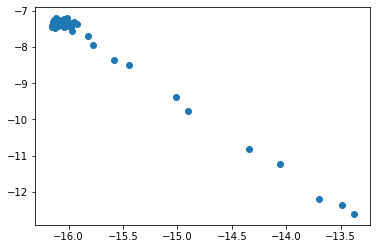

In [12]:
plt.scatter(np.real(result_data), np.imag(result_data))

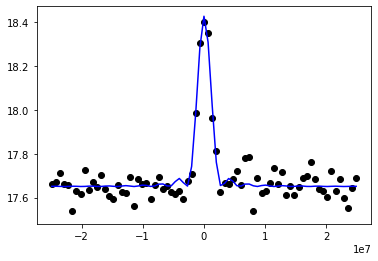

In [13]:
cal.fit_results_f01(result_data,frequencies)

In [15]:
cal.df01_calib/cal.f01_default

7.135638799529116e-06

# amplitude 01

In [68]:
drive_powers,schedules = cal.amplitude01_schedules()

In [17]:
result_data = cal.run_schedule(schedules)

Job Status: job has successfully run


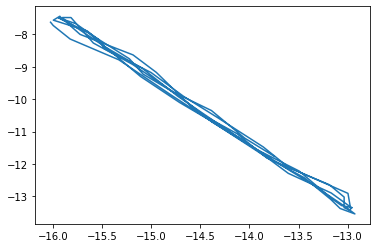

In [18]:
plt.plot(np.real(result_data), np.imag(result_data))

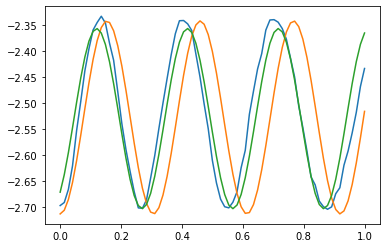

In [19]:
cal.fit_results_a01(result_data,drive_powers)

In [20]:
cal.a01_calib

0.14917816517791702

# frequency 21

In [69]:
frequencies,schedules = cal.frequency12_schedules()

In [36]:
result_data = cal.run_schedule(schedules)

Job Status: job has successfully run


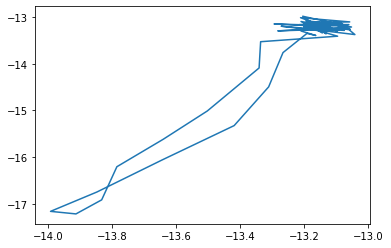

In [37]:
plt.plot(np.real(result_data), np.imag(result_data))

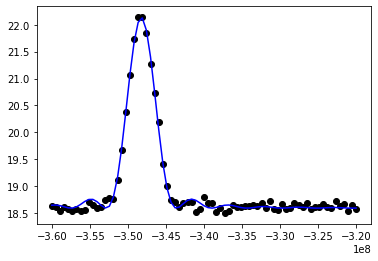

In [42]:
cal.fit_results_f12(result_data,frequencies)

In [43]:
cal.df12_calib

-348238083.6366866

# amplitude 21

In [70]:
drive_powers,schedules = cal.amplitude12_schedules()

In [49]:
result_data = cal.run_schedule(schedules)

Job Status: job has successfully run


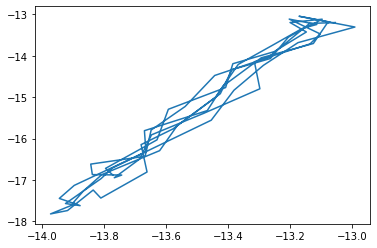

In [50]:
plt.plot(np.real(result_data), np.imag(result_data))

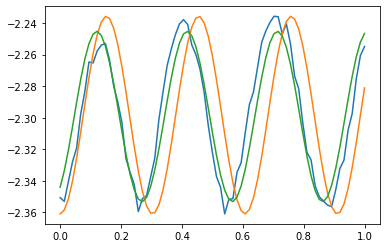

In [61]:
cal.fit_results_a12(result_data,drive_powers)

In [66]:
cal.a12_calib

0.1483563540171458

# measurements

In [127]:
states,schedules = cal.measurement_schedule()

In [129]:
result_data = cal.run_schedule(schedules,boolAvg=False)

Job Status: job has successfully run


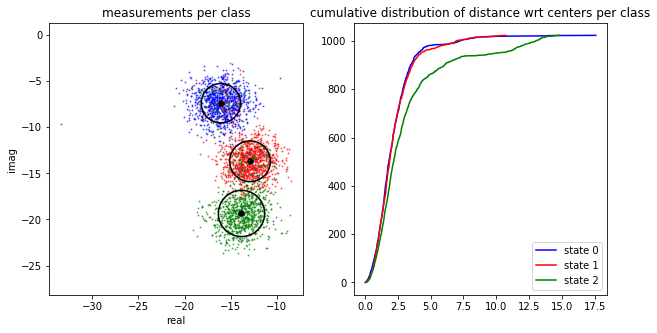

In [241]:
cal.fit_measurements(result_data)

In [243]:
print(cal.confusion_matrix)

[[0.95117188 0.04589844 0.00292969]
 [0.06445312 0.90625    0.02929688]
 [0.08203125 0.125      0.79296875]]
